# Uniform Manifold Approximation and Projection (UMAP)

In [1]:
# ! pip install umap-learn

In [2]:
# ## plotting functionality
# ! pip install umap-learn[plot] 

In [3]:
# ! pip install --upgrade tensorflow-probability

In [4]:
# import sklearn.datasets
import pandas as pd
import numpy as np

# import scipy.sparse as sp
from scipy import sparse

## Clustering evaluation
# import numpy as np
from sklearn import metrics
from sklearn.metrics import pairwise_distances
# from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
import umap
import umap.plot

### 2 classes: IAV (Index 0 to 40) & Human (Index 41 to 15684)

In [6]:
protein_list = pd.read_csv('protein_class.csv') 
protein_list

,Unnamed: 0,Protein1_ID,class,IAV Segment,IAV Strain
0,0,P03428,IAV,PB2,PR8
1,1,P03431,IAV,PB1,PR8
2,2,P03433,IAV,PA,PR8
3,3,P03452,IAV,HA,PR8
4,4,P03466,IAV,NP,PR8
...,...,...,...,...,...
15680,15680,Q6NUS8,Human,NaN,NaN
15681,15681,P12018,Human,NaN,NaN
15682,15682,Q96IU2,Human,NaN,NaN
15683,15683,Q6PEW1,Human,NaN,NaN


In [7]:
protein_list[:41]

,Unnamed: 0,Protein1_ID,class,IAV Segment,IAV Strain
0,0,P03428,IAV,PB2,PR8
1,1,P03431,IAV,PB1,PR8
2,2,P03433,IAV,PA,PR8
3,3,P03452,IAV,HA,PR8
4,4,P03466,IAV,NP,PR8
5,5,P03468,IAV,NaN,PR8
6,6,P03485,IAV,M1,PR8
7,7,P03496,IAV,NS1,PR8
8,8,P06821,IAV,M2,PR8
9,9,P03508,IAV,NS2,PR8


In [8]:
protein_list['class'].value_counts()

Human    15644
IAV         41
Name: class, dtype: int64

# Node Embeddings

In [9]:
def retrieve_node_emb(hyper_param, file_format, init_emb_type): ## csv_file, txt_file, emb_file
    
    if init_emb_type == 'graph':
        
        edit_data_path = 'Embeddings/Graph/Best/Nov_2022/' 
        
        if file_format == 'csv_file': 
            ## deepwalk, node2vec, struc2vec
            emb = pd.read_csv(edit_data_path + hyper_param + '.csv', skiprows=1, header = None)

        elif file_format == 'txt_file':
            ## LINE, SDNE, GraRep, VAE, ripple2vec
            emb = pd.read_csv(edit_data_path + hyper_param + '.txt', sep=' ', skiprows=1, header = None)

        elif file_format == 'emb_file':
            ## node2vec+ 
            emb = pd.read_csv(edit_data_path + hyper_param + '.emb', sep=' ', skiprows=1, header = None)

        emb_f = emb.sort_values(by=[0]).set_index([0])
        features = emb_f.sort_index().values
        
    ## Protein embedding 
    elif (file_format == 'placeholder') & (init_emb_type == 'protein'):
        
        edit_data_path = 'Embeddings/Protein/' + hyper_param 
        
        ## Load npz
        read_emb = sparse.load_npz(edit_data_path + '.npz')
        features = read_emb.toarray()
    
    print(features.shape)
    print(features)
        
    return features

# Edge Embeddings

#### Hadamard

In [10]:
## Get edge embeddings from node embeddings
def generate_edge_emb_hadamard(input_df, input_feat):
    
    edges_count = input_df.shape[0]

    X = np.empty((edges_count, input_feat.shape[1])) ## All embeddings
    k = 0

    for i in range(len(input_df)):

#         print(input_df['Protein1_ID'][i], input_df['Protein2_ID'][i])

        u = input_feat[input_df['Protein1_ID'][i]]
        v = input_feat[input_df['Protein2_ID'][i]]

        hadamard = np.multiply(u, v)

        X[k] = hadamard
        k = k + 1

    print(X)
    print(X.shape)
    
    ## Target
    target = input_df['Class'].values
    y_true = input_df['Label'].values
    
#     target = input_df['Class_3'].values
#     y_true = input_df['Label_3'].values
    
    return X, target, y_true

#### Concatenation

In [11]:
def concat_emb(input_df, input_feat):
    
    edges_count = input_df.shape[0]

    X = np.empty((edges_count, 2*input_feat.shape[1]))
    k = 0 ## array index
    
    for i in range(len(input_df)):
        
        u = input_feat[input_df['Protein1_ID'][i]]
        v = input_feat[input_df['Protein2_ID'][i]]
        
        u_v = np.hstack((u, v)) ## Stack embeddings of two proteins together
        
        X[k] = u_v
        k = k + 1
    
    print(X)
    print(X.shape)
    
    ## Target
    target = input_df['Class'].values
    y_true = input_df['Label'].values
    
    return X, target, y_true

# Metrics

In [12]:
def get_metrics(get_edge_emb, true_labels, pred_labels):
    
    h = metrics.homogeneity_score(true_labels, pred_labels)
    c = metrics.completeness_score(true_labels, pred_labels)
    v = metrics.v_measure_score(true_labels, pred_labels)
    
    fm = metrics.fowlkes_mallows_score(true_labels, pred_labels)
    
    ## adjusted_rand_score
    a_rand = metrics.adjusted_rand_score(true_labels, pred_labels) 
    a_mut_info = metrics.adjusted_mutual_info_score(true_labels, pred_labels)
    
    s = metrics.silhouette_score(get_edge_emb, pred_labels, metric='euclidean')
#     db = davies_bouldin_score(get_edge_emb, pred_labels)
#     ch = metrics.calinski_harabasz_score(get_edge_emb, pred_labels)
    
    return([h, c, v, fm, a_rand, a_mut_info, s])

# Run Program here

In [13]:
### Load dataframe
## All edges used to train embeddings

'''
    Class, Label: Split Positive threshold only
    Class_2, Label_2: Split Positive & Negative threshold 
    Class_3, Label_3: No threshold
'''

'\n    Class, Label: Split Positive threshold only\n    Class_2, Label_2: Split Positive & Negative threshold \n    Class_3, Label_3: No threshold\n'

In [14]:
## All edges
tt_df = pd.read_csv('./hvppi_preds/hvppi_edgelist_idx.csv')

tt_df

,Unnamed: 0,Protein1_ID,Protein2_ID,Score,Class,Label,Class_2,Class_3,Label_3,Label_2
0,0,9561,7,0.990,0.99,2,0.99,pos,1,5
1,1,11092,7,0.988,0.99,2,0.99,pos,1,5
2,2,2803,7,0.988,0.99,2,0.99,pos,1,5
3,3,10381,7,0.985,0.99,2,0.99,pos,1,5
4,4,1068,7,0.983,0.99,2,0.99,pos,1,5
...,...,...,...,...,...,...,...,...,...,...
272071,272071,14358,30,0.001,neg,0,<=0.047,neg,0,0
272072,272072,4604,30,0.001,neg,0,<=0.047,neg,0,0
272073,272073,9166,30,0.001,neg,0,<=0.047,neg,0,0
272074,272074,14775,30,0.001,neg,0,<=0.047,neg,0,0


In [15]:
tt_df['Class'].value_counts()

neg     223194
0.90     30228
0.95     15782
0.99      2872
Name: Class, dtype: int64

In [16]:
'''
    Interacting edges only (48, 882)

    2872 0.99
    15,782 0.95
    30,228 0.90

'''
# tt_df_pos = tt_df[tt_df['Score'] >= 0.143]
# print(tt_df_pos)

# print(tt_df_pos['Class'].value_counts())

'\n    Interacting edges only (48, 882)\n\n    2872 0.99\n    15,782 0.95\n    30,228 0.90\n\n'

In [17]:
### Train, Validation, Test

# tt_df = pd.read_csv('./umap_tt_df.csv') ## 3 classes

### Label
# tt_df.loc[tt_df['Class'] == '0.99', 'Label'] = 2
# tt_df.loc[tt_df['Class'] == '0.95', 'Label'] = 1
# tt_df.loc[tt_df['Class'] == 'neg', 'Label'] = 0

# tt_df['Label'] = tt_df['Label'].astype(int)

# tt_df

In [18]:
### Experimentally verified dataset

## Positive
# pos_org = pd.read_csv('edges/Sept_2022_new/balanced/idx/b_pos_idx.csv').drop(columns={'label'})
# pos_org

## Negative
# neg_org = pd.read_csv('edges/Sept_2022_new/balanced/idx/b_neg_idx.csv').drop(columns={'label'})
# neg_org

## Testset
# test_df = pd.read_csv('edges/Experimentally_Verified_Test/testset_1.csv')
    
# pos_test = test_df[test_df['label'] == 1].drop(columns={'label'})
# neg_test = test_df[test_df['label'] == 0].drop(columns={'label'})

### Assign labels
## (neg_train), 1 (pos_train), 2 (neg_test), 3 (pos_test)
# neg_org['Label'] = 0
# neg_org['Class'] = 'neg_train'

# pos_org['Label'] = 1
# pos_org['Class'] = 'pos'

# neg_test['Label'] = 2
# neg_test['Class'] = 'neg_test'

# pos_test['Label'] = 1
# pos_test['Class'] = 'pos_test'

# expt_df = pd.concat([neg_org, pos_org, pos_test, neg_test], ignore_index=True)
# expt_df

### Loop

In [19]:
# def run_evaluation(mtd_name, f_format_name, get_df, emb_type):
    
#     g_features = retrieve_node_emb(mtd_name, f_format_name, emb_type) 
    
#     edge_emb_arr, class_labels, labels_true = generate_edge_emb_hadamard(get_df, g_features) ## Hadamard
    
#     ## K-means clustering
#     kmeans_model = KMeans(n_clusters=4, random_state=1).fit(edge_emb_arr) ## Actual dimensions
#     labels = kmeans_model.labels_
    
#     ## Clustering evaluation
#     metrics_arr = get_metrics(edge_emb_arr, labels_true, labels)
    
#     ## Round all elements in metrics_arr to 4 d.p.
#     metrics_arr_r = np.round(metrics_arr, 4)
#     print(metrics_arr_r)
    
#     ## Write to file
# #     with open('Eval_Results/emb_eval_train_test.txt', "a") as f:
#     with open('Eval_Results/clustering_evaluation_all_edges.txt', "a") as f:
#         f.write(mtd_name + ': ' + str(metrics_arr_r) + '\n')

In [20]:
# ## Graph Embeddings

# mtd_arr = ['deepwalk_nw16_wl32', 'node2vec_nw8_wl32_p0.25_q0.5', 'struc2vec_nw128_wl16', 
#            'ripple2vec_nw8_wl8', 'LINE_order3_epochs10', 'sdne_a0_b10', 'vae_h256_128', 'grarep_k2',
#            'n2vplus_nw8_wl32_p0.25_q0.5']

# f_format_arr = ['csv_file', 'csv_file', 'csv_file', 
#                'txt_file', 'txt_file', 'txt_file', 'txt_file', 'txt_file', 
#                 'emb_file']

# for i, j in zip(mtd_arr, f_format_arr):
#     run_evaluation(i, j, tt_df, 'graph')

In [21]:
# ### Protein Embeddings
# mtd_arr = ['AAC', 'APAAC', 'CT', 'CTD', 'DPC', 'NMBroto', 'QSOrder']

# for i in range(len(mtd_arr)):
#     run_evaluation(mtd_arr[i], 'placeholder', tt_df, 'protein')

### Individual

In [22]:
'''
    Methods
'''
# mtd_arr = ['deepwalk_nw16_wl32', 'node2vec_nw8_wl32_p0.25_q0.5', 'struc2vec_nw128_wl16', 
#            'ripple2vec_nw8_wl8', 'LINE_order3_epochs10', 'sdne_a0_b10', 'vae_h256_128', 'grarep_k2',
#            'n2vplus_nw8_wl32_p0.25_q0.5']

## csv_file, txt_file, emb_file

'\n    Methods\n'

In [23]:
g_features = retrieve_node_emb(hyper_param='struc2vec_nw128_wl16', file_format='csv_file', init_emb_type='graph')

edge_emb_arr, class_labels, labels_true = generate_edge_emb_hadamard(input_df=tt_df, input_feat=g_features) ## Hadamard
# edge_emb_arr, class_labels, labels_true = concat_emb(input_df=tt_df, input_feat=g_features) ## Concatenation

(15685, 128)
[[-0.34090361  0.00490388  0.15034263 ... -0.62056339 -0.77751833
   0.04459065]
 [-0.30231121  0.05330231  0.04540502 ... -0.65847135 -0.70260775
   0.20529708]
 [-0.37053573  0.03047679  0.04566829 ... -0.66611922 -0.71744794
   0.19801114]
 ...
 [-0.57823092  0.07458004  0.37632829 ... -0.51734591 -0.2579461
   0.5737536 ]
 [ 0.42405364  0.04703537 -0.67445052 ... -0.11248438 -0.54566306
   0.05261261]
 [-0.15835829  0.28309751  0.16477866 ...  0.16229083 -0.15534198
   0.03207009]]
[[-6.07973940e-02  9.68219082e-03 -2.99820680e-04 ...  1.58586849e-01
   1.01882419e-01 -3.03472685e-03]
 [-6.75474454e-02  6.24479926e-03 -1.34648392e-03 ...  1.88533321e-01
   5.80571969e-02 -2.17535436e-02]
 [-1.45509703e-01  4.35910401e-03 -7.03814449e-03 ...  1.40970107e-01
   3.91548100e-01  2.60560855e-03]
 ...
 [ 7.22247191e-02  1.27866263e-02  4.75555278e-02 ...  4.47984294e-01
   7.50797949e-01  1.20755375e-02]
 [ 1.85989708e-01  5.76451644e-03  1.98948210e-02 ...  2.37398216e-01
 

#### Metrics

In [24]:
# '''
#     Metrics
# '''
# ## K-means clustering
# kmeans_model = KMeans(n_clusters=4, random_state=1).fit(edge_emb_arr) ## without dimensionality reduction
# # kmeans_model = KMeans(n_clusters=4, random_state=1).fit(reduced_features) ## with dimensionality reduction
# labels = kmeans_model.labels_

# ## Clustering evaluation
# metrics_arr = get_metrics(get_edge_emb = edge_emb_arr, true_labels = labels_true, pred_labels = labels)

# ## Round all elements in metrics_arr to 4 d.p.
# metrics_arr_r = np.round(metrics_arr, 4)
# print(metrics_arr_r)

In [25]:
# print(labels)
# print(len(labels))

# unique, counts = np.unique(labels, return_counts=True)
# print(unique, counts)

#### UMAP

<AxesSubplot:>

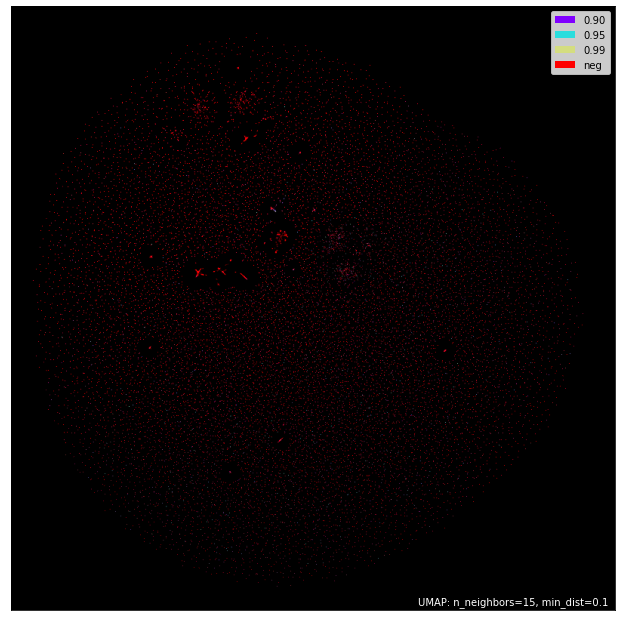

In [26]:
mapper = umap.UMAP().fit(edge_emb_arr)
umap.plot.points(mapper, labels=class_labels, theme='fire')

<AxesSubplot:>

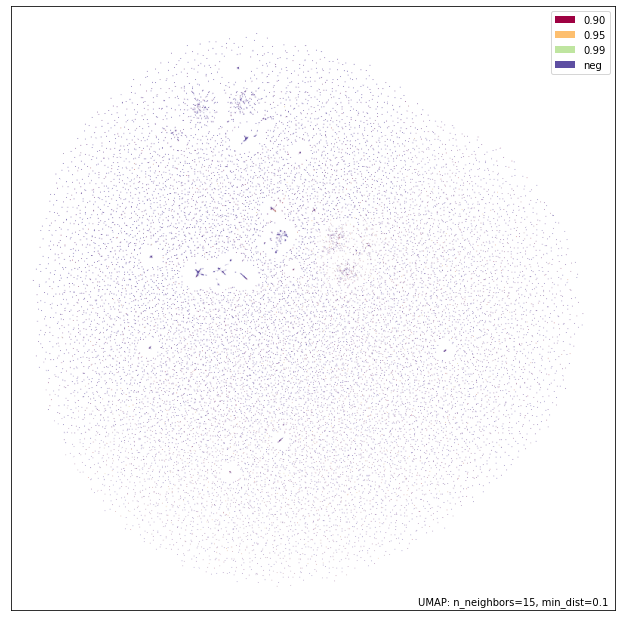

In [27]:
umap.plot.points(mapper, labels=class_labels)

In [28]:
# ## UMAP dimensionality reduction
# fit = umap.UMAP()
# reduced_features = fit.fit_transform(edge_emb_arr)
# reduced_features

In [29]:
# umap.plot.points(mapper, labels=class_labels)

## Plot K-means

### Dimensionality Reduction

In [30]:
# labels_true

In [31]:
# unique, counts = np.unique(labels_true, return_counts=True)
# print(unique, counts)

In [32]:
# # Plotting the results
# def plt_kmeans_scatter(dim_reduction_mtd, ground_truth, num_clusters):
    
#     if dim_reduction_mtd == 'UMAP':
#         fit = umap.UMAP()
#         reduced_features = fit.fit_transform(edge_emb_arr)
    
#     elif dim_reduction_mtd == 'PCA':
#         pca = PCA(2)
#         reduced_features = pca.fit_transform(edge_emb_arr)
        
#     print(reduced_features)
#     print(reduced_features.shape)
    
#     ## K-means clustering
#     kmeans_model = KMeans(n_clusters=num_clusters)
#     labels = kmeans_model.fit_predict(reduced_features) ## with dimensionality reduction
    
#     '''
#         Clustering evaluation
#     ''' 
#     metrics_arr = get_metrics(get_edge_emb = reduced_features, true_labels = ground_truth, pred_labels = labels)

#     ## Round all elements in metrics_arr to 4 d.p.
#     metrics_arr_r = np.round(metrics_arr, 4)
#     print(metrics_arr_r)
    
#     '''
#         Scatter plot
#     '''
#     # Getting unique labels
#     u_labels = np.unique(label)
    
    
#     # Getting the Centroids
#     centroids = kmeans.cluster_centers_
#     u_labels = np.unique(labels)
    
#     for i in u_labels:
#         print(i)
#         plt.scatter(reduced_features[labels == i , 0] , reduced_features[labels == i , 1] , labels = i)
    
#     plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    
# #     ## Filter rows of original data (True labels)
# #     label_0 = reduced_features[labels_true == 0]
# #     label_1 = reduced_features[labels_true == 1]
# #     label_2 = reduced_features[labels_true == 2]
# #     label_3 = reduced_features[labels_true == 3]
    
#     print(len(label_0), len(label_1), len(label_2))

#     arr_0 = plt.scatter(label_0[:,0] , label_0[:,1]) ## plt.scatter(edge 1, edge 2)
#     arr_1 = plt.scatter(label_1[:,0] , label_1[:,1]) 
#     arr_2 = plt.scatter(label_2[:,0] , label_2[:,1])
#     arr_3 = plt.scatter(label_3[:,0] , label_3[:,1])
    
                
#     plt.legend([arr_0, arr_1, arr_2, arr_3], ['neg', '0.90', '0.95','0.99'])
#     plt.show()

In [33]:
# plt_kmeans_scatter('UMAP', labels_true, 4) ## (dim_reduction_mtd, num_clusters)

In [34]:
# plt_kmeans_scatter('PCA', labels_true, 4)

## Plot

In [35]:
# mapper = umap.UMAP().fit(edge_emb_arr)

In [36]:
# umap.plot.points(mapper, labels=class_labels, theme='fire')
# umap.plot.points(mapper, labels=class_labels)

In [37]:
## PCA
# umap.plot.diagnostic(mapper, diagnostic_type='pca') ##  looking for here is a generally smooth transition of colors

In [38]:
## Local dimensions
## Embeddings more accurate in regions where the points have consistently lower local dimension.
# local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')

In [39]:
# umap.plot.diagnostic(mapper, diagnostic_type = 'vq')

In [40]:
# umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')